### Предсказание отклика банковских клиентов на основе данных маркетинговой кампании португальских банков

In [391]:
import matplotlib as mpl

mpl.rcdefaults() 


In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
import matplotlib as mpl


df = pd.read_csv("10_banking.csv")
df.shape
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [393]:
df.shape

(41188, 21)

In [394]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [395]:
df.groupby("y")["y"].count()#классы сильно не сбалансированы

y
0    36548
1     4640
Name: y, dtype: int64


 Описание колонок:
age - возраст клиента 

job - тип работы 

marital - статус замужества

education - степень образования 

default - дефолтил ли клиент?

housing - есть ли жилищный кредит?

loan - есть ли потребительский кредит?

contact - тип коммуникации

month - месяц последнего контакта 

day_of_week - день недели последнего контакта 

duration - длительность последнего звонка - стоит убрать при обучении модели

campaign - количество звонков в течение маркетинговой кампании 

pdays - как давно не было коммуникации с клиентом, относительно предыдущей маркетинговой кампании

previous - количество звоноков до текущей маркетинговой компании

poutcome - результат предыдущей маркентинговой кампании относительно выбранного клиента 

emp.var.rate - коэффициент вариации безработицы (quarterly)

cons.price.idx - индекс потребительских цен (monthly)

cons.conf.idx: - индекс потребительской уверенности (monthly)

euribor3m - межбанковская европейская ставка предложения по трехмесячному займу (daily)

nr.employed - количество занятых 

y -**таргетная переменная: взял ли клиент депозит** 


**Наша целевая переменная - взял ли клиент депозит.**

In [396]:
### Уберем колонку duration

df = df.drop('duration', axis=1)

In [397]:
df.dtypes


age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [398]:
### Посмотрим на некатегориальные колонки

numeric_columns = df.select_dtypes(exclude='object').columns
df.select_dtypes(exclude='object').head(2)

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0
1,53,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0


In [399]:
### Посмотрим на категориальные колонки

categorical_columns =  df.select_dtypes(include='object').columns
df.select_dtypes(include='object').head(2)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,nonexistent
1,technician,married,unknown,no,no,no,cellular,nov,fri,nonexistent


### Развернем EDA на категориальных колонках. А так же методы фильтрации на вещественных. Вдруг от каких-то получится избавиться заранее, чтобы не плодить огромный датасет!

In [400]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [401]:
### Есть ли пропуски?

df.describe()

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [402]:
### Изучим корелляции вещественных признаков

cor=df[numeric_columns].corr()
cor

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
age,1.000000,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
campaign,0.004594,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp_var_rate,-0.000371,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons_price_idx,0.000857,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons_conf_idx,0.129372,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr_employed,-0.017725,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678
y,0.030399,-0.066357,-0.324914,0.230181,-0.298334,-0.136211,0.054878,-0.307771,-0.354678,1.000000


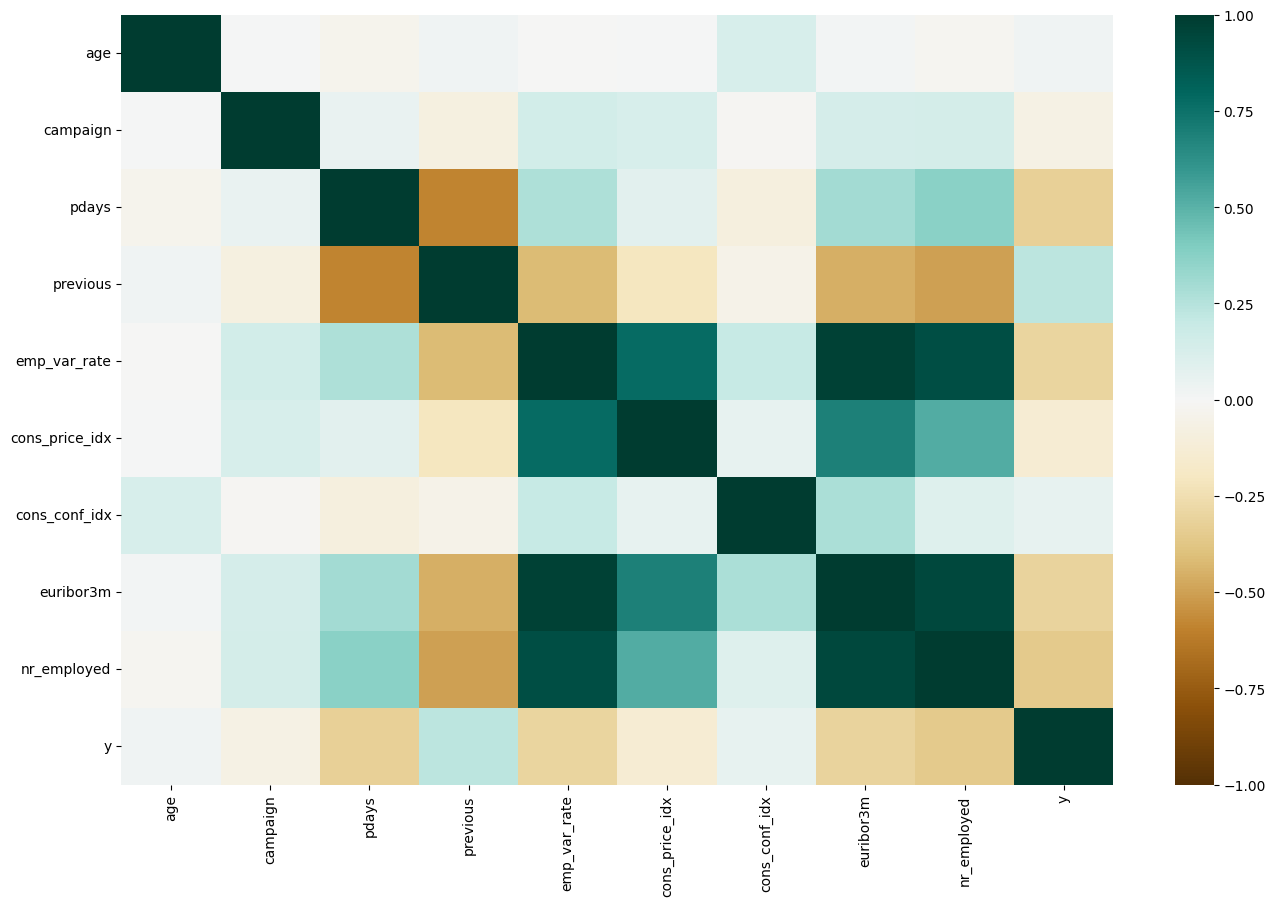

In [403]:
### Изобразим в виде Тепловой карты

import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[numeric_columns].corr(), 
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

In [404]:
len(df)

41188

In [405]:
df.shape

(41188, 20)

In [406]:
correlated_features = set()
for i in range(len(cor.columns)):
    for j in range(i):
        if (abs(cor.iloc[i, j]) != 1.0)&(abs(cor.iloc[i, j]) > 0.9):
            colname1 = cor.columns[i]
            colname2 = cor.columns[j]
            print(abs(cor.iloc[i, j]), "--", i, '--', j, '--', colname1, '--', colname2)
            correlated_features.add(colname1)
            correlated_features.add(colname2)

0.9722446711516101 -- 7 -- 4 -- euribor3m -- emp_var_rate
0.9069701012560608 -- 8 -- 4 -- nr_employed -- emp_var_rate
0.9451544313982743 -- 8 -- 7 -- nr_employed -- euribor3m


In [407]:
df = df.drop(['emp_var_rate', 'euribor3m'], axis=1)
numeric_columns = numeric_columns.drop(['emp_var_rate', 'euribor3m'])

In [408]:
### Посмотрим на квазиконстантые признаки
from sklearn.feature_selection import VarianceThreshold


cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])

cutter.get_feature_names_out()

array(['age', 'campaign', 'pdays', 'previous', 'cons_price_idx',
       'cons_conf_idx', 'nr_employed'], dtype=object)

In [409]:
numeric_columns=numeric_columns.drop(['y'])
numeric_columns

Index(['age', 'campaign', 'pdays', 'previous', 'cons_price_idx',
       'cons_conf_idx', 'nr_employed'],
      dtype='object')

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


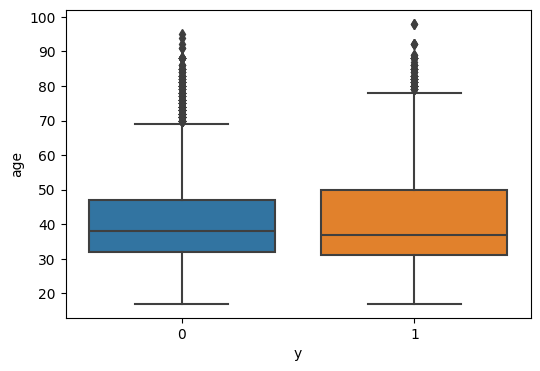

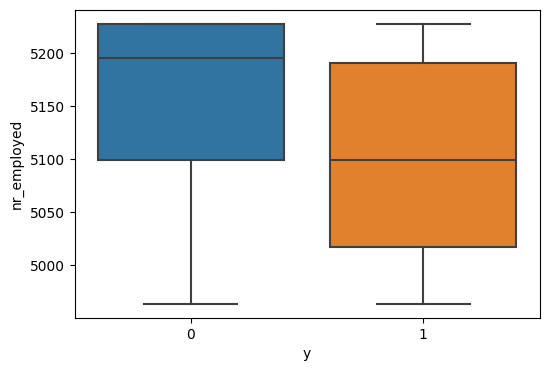

In [410]:
### Еще один способ, как в задаче классификации без построения модели
### оценить важность вещественных признаков- с помощью ящиков с усами, представляя таргет как категорию



num_col = ['age', 'nr_employed']

for col in num_col:
    
    fig = plt.figure()
    fig.set_size_inches(6, 4)
    
    sns.boxplot(y=col, x=df['y'].astype('category'), data=df)
    
plt.show()

#ВИДИМ -РАСПРЕДЕЛЕНИЯ РАЗНЫЕ

In [411]:
### Посмотрим на распределение категорий среди разных таргетов

df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


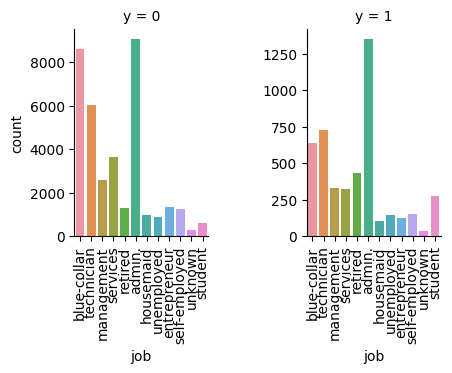

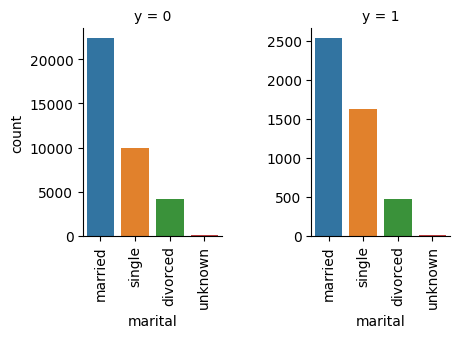

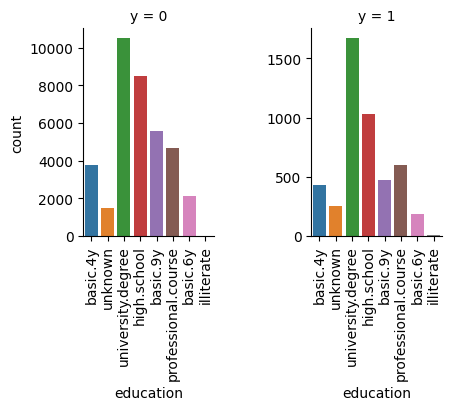

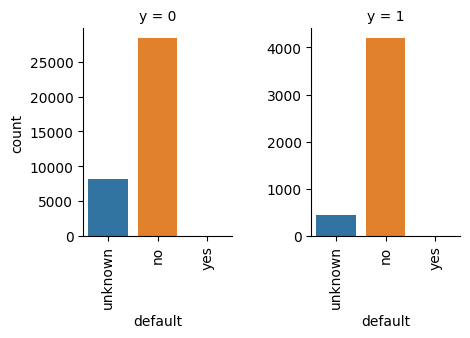

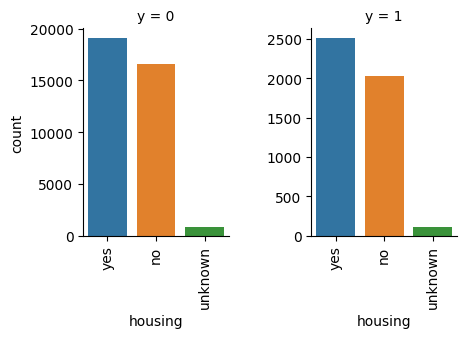

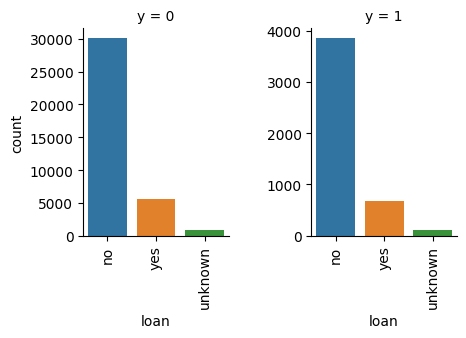

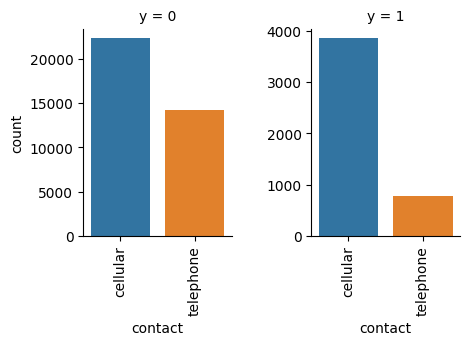

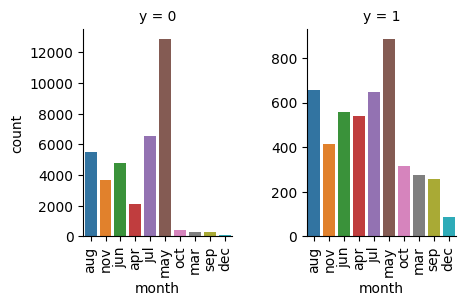

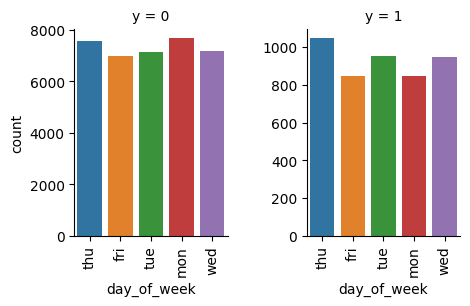

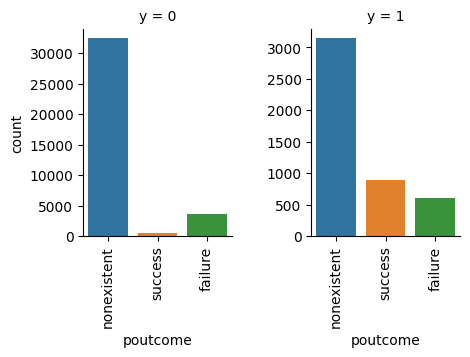

In [412]:
### Гистограммы распределений в разных классах

for col in categorical_columns:
    g = sns.catplot(x=col, kind='count', col='y', data=df, sharey=False, height=3, aspect=0.8)
    g.set_xticklabels(rotation=90)
    
    #Видим что housing Loan marital в целевых классах имеют одинаковое распределение-уберем их

In [413]:
df = df.drop(['loan', 'housing', 'marital'], axis=1)
categorical_columns = categorical_columns.drop(['loan', 'housing', 'marital'])

In [414]:
df.head().shape

(5, 15)

### Закодируем оставшиеся категориальные фичи!

In [415]:
### Посмотрим, какие можно кодировать с помощью one-hot метода, 
### а для каких лучше посчитать счетчики!

df.describe(include='object')

,job,education,default,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188
unique,12,8,3,2,10,5,3
top,admin.,university.degree,no,cellular,may,thu,nonexistent
freq,10422,12168,32588,26144,13769,8623,35563


In [416]:
for col in categorical_columns:
    one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True,dtype=int)
    df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)


In [417]:
df.head()

,age,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,y,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,44,1,999,0,93.444,-36.1,5228.1,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,53,1,999,0,93.200,-42.0,5195.8,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,28,3,6,2,94.055,-39.8,4991.6,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,39,2,999,0,93.075,-47.1,5099.1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,55,1,3,1,92.201,-31.4,5076.2,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [418]:
X = df.drop('y', axis=1)
Y = df['y']

In [419]:
X

,age,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,job_blue-collar,job_entrepreneur,job_housemaid,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,44,1,999,0,93.444,-36.1,5228.1,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,53,1,999,0,93.200,-42.0,5195.8,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,28,3,6,2,94.055,-39.8,4991.6,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,39,2,999,0,93.075,-47.1,5099.1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,55,1,3,1,92.201,-31.4,5076.2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,1,999,0,94.465,-41.8,5228.1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
41184,31,2,999,0,93.994,-36.4,5191.0,0,0,1,...,1,0,0,0,0,1,0,0,1,0
41185,42,3,999,0,93.994,-36.4,5191.0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
41186,48,2,999,0,92.431,-26.9,5017.5,0,0,0,...,0,0,1,0,0,0,1,0,1,0


### Обучим Логистическую регрессию!

In [420]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.3)
X_train

,age,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,job_blue-collar,job_entrepreneur,job_housemaid,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
31880,31,1,999,1,93.200,-42.0,5195.8,0,0,0,...,0,1,0,0,0,0,1,0,0,0
38177,44,1,999,0,93.994,-36.4,5191.0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2459,43,1,999,0,93.994,-36.4,5191.0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
756,35,2,999,0,93.200,-42.0,5195.8,1,0,0,...,0,1,0,0,0,0,1,0,1,0
11275,33,2,999,1,92.893,-46.2,5099.1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,57,7,999,0,93.994,-36.4,5191.0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
32103,36,3,999,0,93.994,-36.4,5191.0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
30403,31,2,999,0,94.465,-41.8,5228.1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
21243,29,2,999,0,92.893,-46.2,5099.1,1,0,0,...,1,0,0,0,0,0,0,0,1,0


In [421]:
from sklearn.preprocessing import StandardScaler

In [422]:
# Шаг 1: Стандартизируем данные
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns]  = scaler.fit_transform(X_test[numeric_columns] )
print(X_train.shape,X_test.shape)


(28831, 43) (12357, 43)


In [423]:
from sklearn.linear_model import  LogisticRegression

In [424]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

### Прогнозирование с использованием обучающих данных

In [425]:
Y_test_pred = logreg.predict(X_test)

In [426]:
from sklearn.metrics import accuracy_score

In [427]:
accuracy_score(Y_test, Y_test_pred)
#'The acuuracy of the model = TP+TN/(TP+TN+FP+FN)

0.9028081249494214

In [428]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_test, Y_test_pred).ravel()

print(f'True Negative errors: {tn}')
print(f'False Positive errors: {fp}')
print(f'False Negative errors: {fn}')
print(f'True Positive errors: {tp}')

True Negative errors: 10826
False Positive errors: 155
False Negative errors: 1046
True Positive errors: 330


<Axes: >

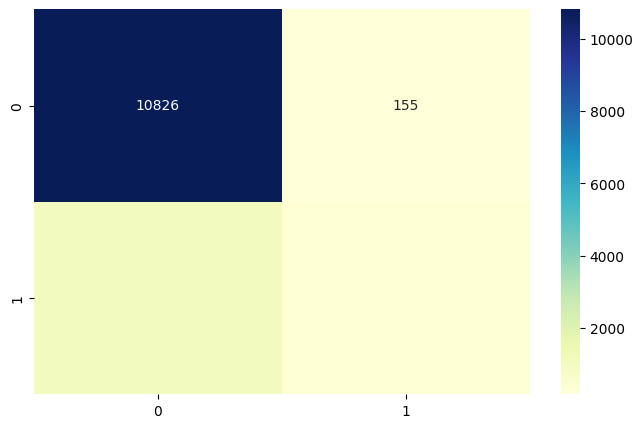

In [429]:
cm = confusion_matrix(Y_test, Y_test_pred)
conf_matrix = pd.DataFrame(data=cm)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [430]:
from sklearn.metrics import precision_score, recall_score, f1_score


In [431]:
precision = precision_score(Y_test, Y_test_pred)
#precision=TP/(TP+FP)-как часто мы классифицируем TP-доля верно-увеличение Precision увеличение захвата возможно полоительных вплоть до ошибок классиф-ии( перевод в true negative)
recall = recall_score(Y_test, Y_test_pred)
#Recall = TP/(TP+FN)-как часто мы находим значение класса d захваченом-из всего набора значений-увеличение Recall- уменьшение ложнонегативных точек( перевод в true positive)
f1 = f1_score(Y_test, Y_test_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.68
Recall: 0.24
F1-Score: 0.35


In [432]:
from sklearn.metrics import precision_recall_curve #эта функция возвращает precision, recall

In [433]:
print(logreg.predict_proba(X_test)[:, 1],len(logreg.predict_proba(X_test)[:, 1]))#12357-такой же размер как у X-test

[0.13381369 0.1057067  0.03970594 ... 0.0540715  0.03616872 0.02746465] 12357


In [434]:
#logreg.predict_proba(X_test)[:, 1]) ---[:, 1]---ВЕРОЯТНОСТИ для каждого обьекта  ПРИНАДЛЕЖНОСТИ К ПОЛОЖИТЕЛЬНОМУ КЛАССУ
precision, recall, thresholds = precision_recall_curve(Y_test, logreg.predict_proba(X_test)[:, 1])
print("Precision:", precision, len(precision))
print("Recall:", recall, len(recall))
print("Thresholds:", thresholds, len(thresholds)) #ПЕРЕБЕРЕМ ВСЕ TRESHOLDы- все отсечки принадлежности к класссу в бин классификации

Precision: [0.11135389 0.1113629  0.11137191 ... 1.         1.         1.        ] 11422
Recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.45348837e-03
 7.26744186e-04 0.00000000e+00] 11422
Thresholds: [0.00209427 0.00464348 0.00656688 ... 0.90298355 0.90719988 0.91299419] 11421


In [435]:
f1_scores = 2 * precision * recall / (precision + recall)


print("Best F-score: ", np.max(f1_scores))
print("Threshold for Best F-score: ", thresholds[np.argmax(f1_scores)])

Best F-score:  0.4884111521666107
Threshold for Best F-score:  0.22480990888223


In [436]:
precision[np.argmax(f1_scores)]

0.4540911930043723

In [437]:
recall[np.argmax(f1_scores)]

0.528343023255814

In [438]:
threshold = thresholds[np.argmax(f1_scores)]
y_pred_prob= (logreg.predict_proba(X_test)[:, 1] > threshold).astype('float')

In [439]:
tn, fp, fn, tp = confusion_matrix(Y_test,y_pred_prob).ravel()

print(f'True Negative errors: {tn}')
print(f'False Positive errors: {fp}')
print(f'False Negative errors: {fn}')
print(f'True Positive errors: {tp}')

True Negative errors: 10108
False Positive errors: 873
False Negative errors: 650
True Positive errors: 726


<Axes: >

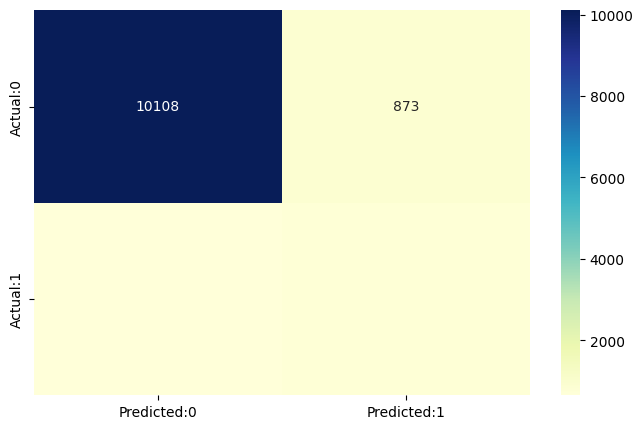

In [440]:
cm = confusion_matrix(Y_test,y_pred_prob)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [441]:
### Получим всевозможные пары FPR, TPR 
### И нарисуем ROC-кривую
from sklearn.metrics import roc_curve
fpr, tpr, threshold=roc_curve(Y_test, logreg.predict_proba(X_test)[:, 1])

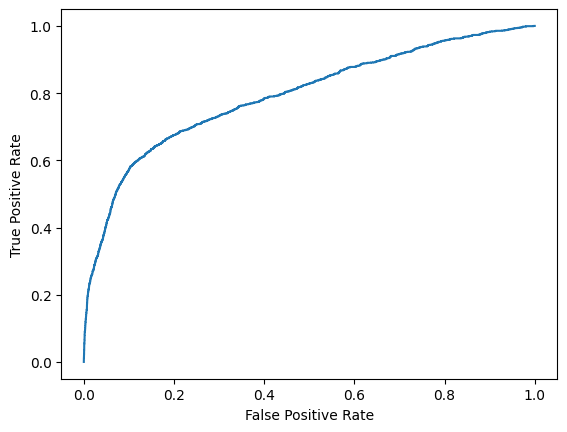

In [442]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [443]:
### Посчитаем ROC-AUC

from sklearn.metrics import auc

auc(fpr, tpr)# НУ ХОТБ ЛУЧШЕ 0,5-случайного угадывания

0.7935625925223907

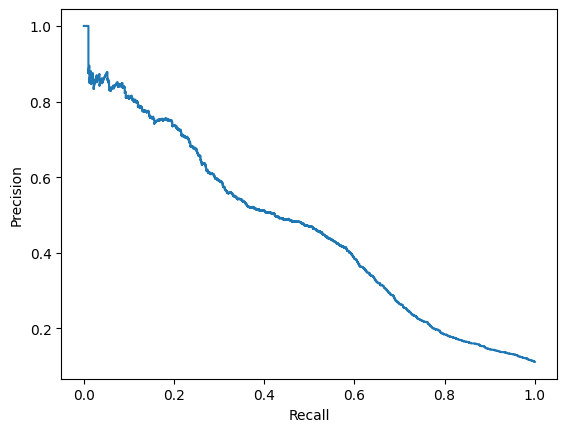

In [444]:
### Получим всевозможные пары Precision, Recall
### И нарисуем PR-кривую
precision, recall, thresholds = precision_recall_curve(Y_test, logreg.predict_proba(X_test)[:, 1])
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [445]:
### Посчитаем PR-AUC
auc(recall, precision) # ТУТ ВИДИМ ФИНАЛ auc-фиговый меньше 0,5 плохая модель

0.46023767849765196

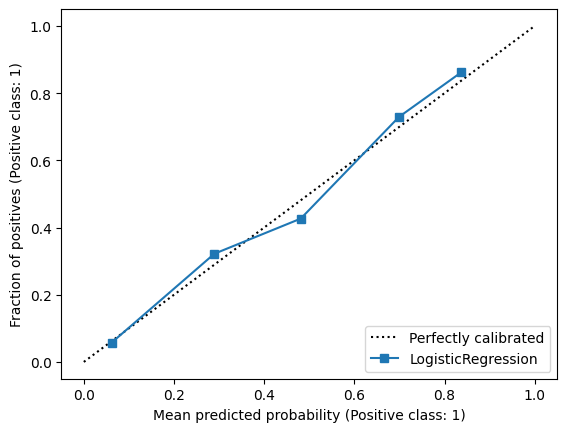

In [446]:
### Нарисуем калибровочную кривую для нашей модели LR



from sklearn.calibration import CalibrationDisplay


CalibrationDisplay.from_estimator(logreg, X_test, Y_test)


In [447]:
print("Train Accuracy:", logreg.score(X_train, Y_train))
print("Test Accuracy:", logreg.score(X_test, Y_test))

Train Accuracy: 0.8989629218549477
Test Accuracy: 0.9028081249494214
